### Stable Diffusion Tutorial

HuggingFace's `diffuser` is a python package for fast experimentation with diffusion models. Let's install it and get started!

In [5]:
! pip install --upgrade diffusers[torch]

#### Diffuser Pipeline

The easiest way to use `diffuser` is through the `DiffuserPipeline` class. This class wraps a `diffuser` model and provides a simple interface for sampling from a pre-trained model. Let's start by importing the class and creating a pipeline.

In this example,  the pipeline already contains a `UNet2DModel` model and a `DDPMScheduler`. 

```python

  0%|          | 0/25 [00:00<?, ?it/s]

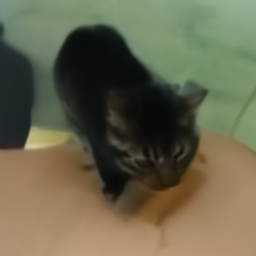

In [6]:
from diffusers import DDPMPipeline

ddpm = DDPMPipeline.from_pretrained("google/ddpm-cat-256").to("cuda")
image = ddpm(num_inference_steps=25).images[0]
image

#### Decomposing the Diffuser Pipeline

Alternatively, the pipeline can be decomposed into its components, a scheduler and a model. This is useful for more advanced use cases, such as training a model from scratch or using a custom scheduler.

```python

In [7]:
from diffusers import DDPMScheduler, UNet2DModel

scheduler = DDPMScheduler.from_pretrained("google/ddpm-cat-256")
model = UNet2DModel.from_pretrained("google/ddpm-cat-256").to("cuda")
scheduler.set_timesteps(25)
scheduler.timesteps

tensor([960, 920, 880, 840, 800, 760, 720, 680, 640, 600, 560, 520, 480, 440,
        400, 360, 320, 280, 240, 200, 160, 120,  80,  40,   0])

#### Inference from noise

Now that we have a pipeline, we can sample from it. Let's start by sampling from noise.

```python

In [8]:
import torch

sample_size = model.config.sample_size
noise = torch.randn((1, 3, sample_size, sample_size)).to("cuda")
noise.shape

torch.Size([1, 3, 256, 256])

#### From noise to image

Starting with noise, at each timestep, the model predicts the noise residual and the scheduler uses it to predict a less noisy image. The pipeline repeats this process until it reaches the end of the specified number of inference steps.

In [9]:
input = noise

for t in scheduler.timesteps:
    with torch.no_grad():
        noisy_residual = model(input, t).sample
    previous_noisy_sample = scheduler.step(noisy_residual, t, input).prev_sample
    input = previous_noisy_sample

### Visualizing the output image

Let's visualize the output image using Pillow.

```python

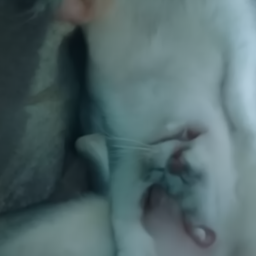

In [10]:
from PIL import Image
import numpy as np

image = (input / 2 + 0.5).clamp(0, 1)
image = image.cpu().permute(0, 2, 3, 1).numpy()[0]
image = Image.fromarray((image * 255).round().astype("uint8"))
image